In [345]:
#vårt projekt

from typing import Tuple

from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
from torch.utils.data import dataset
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import LambdaLR
import random
import numpy as np
import math

import matplotlib.pyplot as plt
from tqdm import tqdm

In [346]:
print(torch.__version__)

2.1.1


In [347]:
# pip install sentencepiece
# pip install tqdm
#conda install pytorch torchvision torchaudio -c pytorch
#python -m pip uninstall pytorch

In [348]:
import sentencepiece as spm

In [349]:
random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)

In [350]:
if torch.cuda.is_available():
    device = 'cuda'

else:
    device = 'cpu'
DEVICE = torch.device(device)
DEVICE


device(type='cpu')

In [351]:
#Alice paths
data_path = '/Users/alicetottie/Downloads/projekt_data/train_paracrawl.en'
data_path_2 = '/Users/alicetottie/Downloads/projekt_data/train_paracrawl.sv'

#Maja paths
# data_path = '/Users/majarygard/Documents/LTH/Projekt i Data/train_paracrawl.en'
# data_path_2 = '/Users/majarygard/Documents/LTH/Projekt i Data/train_paracrawl.sv'

#Pernilla paths
#data_path = 'C:\\Users\\nilla\\Plugg\\project-data\\train_paracrawl.en\\train_paracrawl.en'
#data_path_2 = 'C:\\Users\\nilla\\Plugg\\project-data\\train_paracrawl.sv\\train_paracrawl.sv'


In [352]:
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")

with open(data_path_2, "r", encoding="utf-8") as f:
    lines2 = f.read().split("\n")    

In [353]:
len(lines)



4960283

In [354]:
len(lines2)

4960283

In [355]:
num_samples = 1000
input_texts = []
target_texts = []

for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text= line.split("\t")
    input_texts.append(input_text)

with open("input_texts.txt", "w", encoding='utf-8') as f:
    for input_text in input_texts:
        f.write('\t'.join(input_text) + '\n')
    
for line in lines2[: min(num_samples, len(lines2) - 1)]:
    target_text= line.split("\t")
    target_texts.append(target_text)  

with open("input_texts.txt", "a", encoding='utf-8') as f:
    for target_text in target_texts:
        f.write('\t'.join(target_text) + '\n') 

In [356]:
input_texts[500]



['" This is my third course and I bought this concept a long time ago.']

In [357]:
target_texts[500]

['" Det här är min tredje kurs och jag har köpt det hela för länge sedan.']

In [358]:
TRAIN_PERCENTAGE = 0.8
train_val = int(TRAIN_PERCENTAGE * num_samples)
train_val

800

In [359]:
text_pairs = list(zip(input_texts, target_texts))
random.shuffle(text_pairs)
input_texts, target_texts = zip(*text_pairs)
input_texts, target_texts = list(input_texts), list(target_texts)


In [360]:
train_input_texts = input_texts[:train_val]
train_target_texts = target_texts[:train_val]

val_input_texts = input_texts[train_val:]
val_target_texts = target_texts[train_val:]

In [361]:
spm.SentencePieceTrainer.train('--input=input_texts.txt --model_prefix=m --vocab_size=8000 --model_type=bpe --pad_id=3')

# makes segmenter instance and loads the model file (m.model)
sp = spm.SentencePieceProcessor()
sp.load('m.model')

sp.SetEncodeExtraOptions("bos:eos")
sp.SetDecodeExtraOptions("bos:eos")

# encode: text => id
print(sp.encode_as_pieces('This is a test'))
print(sp.encode_as_ids('This is a test'))

# decode: id => text
print(sp.decode_pieces(['▁This', '▁is', '▁a', '▁t', 'est']))
print(sp.decode_ids([1, 665, 64, 5, 4, 134, 2]))

['<s>', '▁This', '▁is', '▁a', '▁test', '</s>']
[1, 1221, 120, 6, 2384, 2]
This is a test
honomill terte


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=input_texts.txt --model_prefix=m --vocab_size=8000 --model_type=bpe --pad_id=3
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: input_texts.txt
  input_format: 
  model_prefix: m
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id:

In [362]:
UNK_IDX, BOS_IDX, EOS_IDX, PAD_IDX = 0, 1, 2, 3

ter
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=3900 all=22766 active=1259 piece=▁"12-
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=4 min_freq=3
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=3920 all=22758 active=1131 piece=▁Egic
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=3940 all=22751 active=1124 piece=▁News
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=3960 all=22750 active=1123 piece=▁calm
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=3980 all=22763 active=1136 piece=▁girl
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=4000 all=22761 active=1134 piece=▁lite
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=4 min_freq=3
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=4020 all=22776 active=1154 piece=▁seen
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=4040 all=22783 active=1161 piece=:9-10)
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=4060 all=22795 active=

In [363]:
def text2codes(texts, sp):
    codes = []
    for text in texts:
        text_l = text[0]
        code = sp.encode_as_ids(text_l)
        n_code = torch.tensor(code)
        codes.append(n_code)

    return codes



In [364]:
train_input_texts[:3], train_target_texts[:3]

([["!!TheM!Z!! hasn't added any friends yet!"],
  ['" Memory / Summerday" gouache/wood/butterfly 48x75 / 48x92cm 2006'],
  ['" child safety in Egypt "" harmfulness of the sun in Egypt on baby skin "" what medications the child in Egypt "" where on holiday with his family to Egypt "" pediatrician "" in which the child free hotels "']],
 [['!!TheM!Z!! har inte lagt till några vänner ännu!'],
  ['"Hågkomst / Sommardag" gouache/trä 48x75 /48x92cm2006'],
  ['" barnsäkerhet i Egypten "" skadlighet solen i Egypten på baby hud "" vilka mediciner barnet i Egypten "" där på semester med sin familj till Egypten "" barnläkare "" där barnet hotellsökningen "']])

In [365]:
text2codes(train_input_texts[:3], sp)[:3]

[tensor([   1,  311, 3644, 7937, 7980,  592,  611, 7958, 7896, 3256,  403, 1955,
          526, 7937,    2]),
 tensor([   1,    8, 7318,  651,  439,   58,  174,  521, 2510, 7907,   52, 6553,
         7964, 2599, 7964, 7915, 7908, 1279, 2964, 4537, 7954, 2461,  439, 4537,
         7954, 1787,  987, 4935,    2]),
 tensor([   1,    8, 4110, 3828, 4522,   37,  158,   75,  175, 7905,  520,  808,
           44,   29, 2646,   37,  158,  153, 4981, 3220,   75,  482, 5682,   29,
         4110,   37,  158,   75, 1312,  153, 2875,  202,  410, 3317,   61,  158,
           75,   31,   35, 2968, 1347,  578,   75,   37,  382,   29, 4110, 3979,
         1948,    8,    2])]

In [366]:
def codes2text(codes):
    texts = []
    for code in codes:
        code_l = list(code)
        for p in code_l:
            texts.append(sp.id_to_piece(p.item()))
    return texts

In [367]:
codes2text(text2codes(train_input_texts[:3], sp)[:3])

['<s>',
 '▁!!',
 'TheM',
 '!',
 'Z',
 '!!',
 '▁hasn',
 "'",
 't',
 '▁added',
 '▁any',
 '▁friends',
 '▁yet',
 '!',
 '</s>',
 '<s>',
 '▁"',
 '▁Mem',
 'ory',
 '▁/',
 '▁S',
 'um',
 'mer',
 'day',
 '"',
 '▁g',
 'ouache',
 '/',
 'wood',
 '/',
 'b',
 'u',
 'tter',
 'fly',
 '▁48',
 'x',
 '75',
 '▁/',
 '▁48',
 'x',
 '92',
 'cm',
 '▁2006',
 '</s>',
 '<s>',
 '▁"',
 '▁child',
 '▁saf',
 'ety',
 '▁in',
 '▁Egypt',
 '▁""',
 '▁har',
 'm',
 'ful',
 'ness',
 '▁of',
 '▁the',
 '▁sun',
 '▁in',
 '▁Egypt',
 '▁on',
 '▁baby',
 '▁skin',
 '▁""',
 '▁what',
 '▁medications',
 '▁the',
 '▁child',
 '▁in',
 '▁Egypt',
 '▁""',
 '▁where',
 '▁on',
 '▁holiday',
 '▁with',
 '▁his',
 '▁family',
 '▁to',
 '▁Egypt',
 '▁""',
 '▁p',
 'ed',
 'iat',
 'ric',
 'ian',
 '▁""',
 '▁in',
 '▁which',
 '▁the',
 '▁child',
 '▁free',
 '▁hotels',
 '▁"',
 '</s>']

In [368]:
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super().__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)
                        * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)
        self.emb_size = emb_size

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding * math.sqrt(self.emb_size)
                            + self.pos_embedding[:token_embedding.size(0), :])

In [369]:
pe = PositionalEncoding(10, 0.1)

In [370]:
torch.zeros(1, 5, 10)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])

In [371]:
pe(torch.zeros(1, 5, 10))

tensor([[[0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111,
          0.0000, 0.0000],
         [0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111,
          0.0000, 1.1111],
         [0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111,
          0.0000, 1.1111],
         [0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 0.0000, 0.0000, 1.1111,
          0.0000, 1.1111],
         [0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111,
          0.0000, 1.1111]]])

In [372]:
# Seq2Seq Network
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import TransformerEncoder, TransformerDecoder, TransformerEncoderLayer, TransformerDecoderLayer

class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super().__init__()
        encoder_layers = TransformerEncoderLayer(emb_size, nhead, dim_feedforward, dropout)
        decoder_layers = TransformerDecoderLayer(emb_size, nhead, dim_feedforward, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_encoder_layers)
        self.transformer_decoder = TransformerDecoder(decoder_layers, num_decoder_layers)

        self.emb_size = emb_size
        self.embedding = nn.Embedding(
            vocab_size, emb_size, padding_idx=PAD_IDX)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)
        self.generator = nn.Linear(emb_size, vocab_size, bias=False)
        self.generator.weight = self.embedding.weight

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.embedding(src))
        tgt_emb = self.positional_encoding(self.embedding(trg))
        
        memory = self.transformer_encoder(src_emb, src_mask, src_padding_mask)
        outs = self.transformer_decoder(tgt_emb, memory, tgt_mask, None,
                                        tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer_encoder(self.positional_encoding(
            self.embedding(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer_decoder(self.positional_encoding(
            self.embedding(tgt)), memory,
            tgt_mask)

In [373]:
# Seq2Seq Network
# class Seq2SeqTransformer(nn.Module):
#     def __init__(self,
#                  num_encoder_layers: int,
#                  num_decoder_layers: int,
#                  emb_size: int,
#                  nhead: int,
#                  vocab_size: int,
#                  dim_feedforward: int = 512,
#                  dropout: float = 0.1):
#         super().__init__()
#         self.transformer = Transformer(d_model=emb_size,
#                                        nhead=nhead,
#                                        num_encoder_layers=num_encoder_layers,
#                                        num_decoder_layers=num_decoder_layers,
#                                        dim_feedforward=dim_feedforward,
#                                        dropout=dropout)

#         self.emb_size = emb_size
#         # Same source and target embs Sect. 3.4
#         self.embedding = nn.Embedding(
#             vocab_size, emb_size, padding_idx=3)
#         self.positional_encoding = PositionalEncoding(
#             emb_size, dropout=dropout)
#         # Bias to be compatible with embeddings
#         self.generator = nn.Linear(emb_size, vocab_size, bias=False)
#         self.generator.weight = self.embedding.weight  # Shared weights Sect. 3.4

#     def forward(self,
#                 src: Tensor,
#                 trg: Tensor,
#                 src_mask: Tensor,
#                 tgt_mask: Tensor,
#                 src_padding_mask: Tensor,
#                 tgt_padding_mask: Tensor,
#                 memory_key_padding_mask: Tensor):
#         src_emb = self.positional_encoding(self.embedding(src))
#         tgt_emb = self.positional_encoding(self.embedding(trg))
#         outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
#                                 src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
#         return self.generator(outs)

#     def encode(self, src: Tensor, src_mask: Tensor):
#         return self.transformer.encoder(self.positional_encoding(
#             self.embedding(src)), src_mask)

#     def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
#         return self.transformer.decoder(self.positional_encoding(
#             self.embedding(tgt)), memory,
#             tgt_mask)


In [374]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float(
        '-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [375]:
generate_square_subsequent_mask(10)

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [376]:
def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),
                           device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1).type(torch.float32)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask


In [377]:
src = pad_sequence(text2codes(
    train_input_texts[:3], sp), padding_value=PAD_IDX)
tgt = pad_sequence(text2codes(
    train_target_texts[:3], sp), padding_value=PAD_IDX)

In [378]:
train_input_texts[:3], train_target_texts[:3]

([["!!TheM!Z!! hasn't added any friends yet!"],
  ['" Memory / Summerday" gouache/wood/butterfly 48x75 / 48x92cm 2006'],
  ['" child safety in Egypt "" harmfulness of the sun in Egypt on baby skin "" what medications the child in Egypt "" where on holiday with his family to Egypt "" pediatrician "" in which the child free hotels "']],
 [['!!TheM!Z!! har inte lagt till några vänner ännu!'],
  ['"Hågkomst / Sommardag" gouache/trä 48x75 /48x92cm2006'],
  ['" barnsäkerhet i Egypten "" skadlighet solen i Egypten på baby hud "" vilka mediciner barnet i Egypten "" där på semester med sin familj till Egypten "" barnläkare "" där barnet hotellsökningen "']])

In [379]:
create_mask(src, tgt)

(tensor([[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]),
 tensor([[0., -inf, -inf,  ..., -inf, -inf, -inf],
         [0., 0., -inf,  ..., -inf, -inf, -inf],
         [0., 0., 0.,  ..., -inf, -inf, -inf],
         ...,
         [0., 0., 0.,  ..., 0., -inf, -inf],
         [0., 0., 0.,  ..., 0., 0., -inf],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  

In [380]:
VOCAB_SIZE = 8000 #max(token2idx.values()) + 1  # or len(token2idx)
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 6
NUM_DECODER_LAYERS = 6


In [381]:
def rate(step, model_size, factor, warmup):
    """
    we have to default the step to 1 for LambdaLR function
    to avoid zero raising to negative power.
    """
    if step == 0:
        step = 1
    return factor * (
        model_size ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5))
    )

In [382]:
transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX, label_smoothing=0.2) #SMOOTHING

optimizer = torch.optim.Adam(
            transformer.parameters(), lr=0.5, betas=(0.9, 0.98), eps=1e-9 #vilken learning rate behövs??
        )
lr_scheduler = LambdaLR( 
        optimizer=optimizer,
        lr_lambda=lambda step: rate(
            step, model_size=transformer.emb_size, factor=1.0, warmup=4000
        ),
    )#lagt till!!

In [383]:
from torch.utils.data import Dataset, DataLoader

In [384]:
class PairDataset(Dataset):
    def __init__(self, input_texts, target_texts, token2idx):
        self.input_texts = input_texts
        self.target_texts = target_texts
        self.token2idx = token2idx

    def __len__(self):
        return len(self.input_texts)

    def __getitem__(self, idx):
        src_batch = text2codes([input_texts[idx]], self.token2idx)
        tgt_batch = text2codes([target_texts[idx]], self.token2idx)

        return src_batch[0], tgt_batch[0]

    def collate(self, batch):
        src_batch, tgt_batch = list(zip(*batch))
        src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
        tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)

        return src_batch, tgt_batch

In [385]:
train_dataset = PairDataset(train_input_texts, train_target_texts, sp)
train_dataloader = DataLoader(train_dataset, batch_size=32,
                              shuffle=True, collate_fn=train_dataset.collate)

In [386]:
val_dataset = PairDataset(val_input_texts, val_target_texts, sp)
val_dataloader = DataLoader(
    val_dataset, batch_size=32, collate_fn=val_dataset.collate)

In [387]:
def train_epoch(model, optimizer, dataloader):
    model.train()
    losses = 0
    sent_cnt = 0
    correct, total = 0, 0
    for src_batch, tgt_batch in tqdm(dataloader):
        src = src_batch.to(DEVICE)
        tgt = tgt_batch.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(
            src, tgt_input)

        logits = model(src,
                       tgt_input,
                       src_mask,
                       tgt_mask,
                       src_padding_mask,
                       tgt_padding_mask,
                       src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(
            logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        lr_scheduler.step() #LAGT TILL
        losses += loss.item()

        with torch.no_grad():
            sent_cnt += tgt_out.size()[-1]

            total += torch.numel(tgt_input)
            _, char_pred = torch.max(logits, -1)
            correct += (char_pred == tgt_out).sum().item()

    return losses / sent_cnt, correct / total


In [388]:
def evaluate(model, dataloader):
    model.eval()
    losses = 0
    sent_cnt = 0
    correct, total = 0, 0

    for src_batch, tgt_batch in dataloader:
        src = src_batch.to(DEVICE)
        tgt = tgt_batch.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(
            src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,
                       src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(
            logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()
        sent_cnt += tgt_out.size()[-1]

        total += torch.numel(tgt_input)
        _, char_pred = torch.max(logits, -1)
        correct += (char_pred == tgt_out).sum().item()

    return losses / sent_cnt, correct / total


In [389]:
from timeit import default_timer as timer
NUM_EPOCHS = 15
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(1, NUM_EPOCHS + 1):
    start_time = timer()
    train_loss, train_acc = train_epoch(
        transformer, optimizer, train_dataloader)
    train_losses += [train_loss]
    train_accs += [train_acc]
    end_time = timer()
    val_loss, val_acc = evaluate(transformer, val_dataloader)
    val_losses += [val_loss]
    val_accs += [val_acc]
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, Train acc.: {train_acc:.3f}, Val acc.: {val_acc:.3f}, Epoch time = {(end_time - start_time):.3f}s"))


100%|██████████| 25/25 [01:11<00:00,  2.86s/it]


Epoch: 1, Train loss: 0.282, Val loss: 0.314, Train acc.: 0.000, Val acc.: 0.000, Epoch time = 71.567s


100%|██████████| 25/25 [01:08<00:00,  2.74s/it]


Epoch: 2, Train loss: 0.279, Val loss: 0.309, Train acc.: 0.002, Val acc.: 0.012, Epoch time = 68.415s


100%|██████████| 25/25 [01:03<00:00,  2.53s/it]


Epoch: 3, Train loss: 0.275, Val loss: 0.304, Train acc.: 0.010, Val acc.: 0.011, Epoch time = 63.278s


100%|██████████| 25/25 [01:09<00:00,  2.76s/it]


Epoch: 4, Train loss: 0.272, Val loss: 0.300, Train acc.: 0.010, Val acc.: 0.011, Epoch time = 69.042s


100%|██████████| 25/25 [01:07<00:00,  2.68s/it]


Epoch: 5, Train loss: 0.269, Val loss: 0.297, Train acc.: 0.010, Val acc.: 0.012, Epoch time = 67.017s


100%|██████████| 25/25 [01:06<00:00,  2.68s/it]


Epoch: 6, Train loss: 0.266, Val loss: 0.294, Train acc.: 0.010, Val acc.: 0.012, Epoch time = 66.998s


100%|██████████| 25/25 [01:05<00:00,  2.63s/it]


Epoch: 7, Train loss: 0.263, Val loss: 0.290, Train acc.: 0.012, Val acc.: 0.012, Epoch time = 65.747s


100%|██████████| 25/25 [01:04<00:00,  2.58s/it]


Epoch: 8, Train loss: 0.259, Val loss: 0.286, Train acc.: 0.013, Val acc.: 0.013, Epoch time = 64.453s


100%|██████████| 25/25 [01:02<00:00,  2.52s/it]


Epoch: 9, Train loss: 0.256, Val loss: 0.282, Train acc.: 0.015, Val acc.: 0.016, Epoch time = 62.882s


100%|██████████| 25/25 [01:07<00:00,  2.70s/it]


Epoch: 10, Train loss: 0.252, Val loss: 0.278, Train acc.: 0.016, Val acc.: 0.017, Epoch time = 67.422s


100%|██████████| 25/25 [01:05<00:00,  2.62s/it]


Epoch: 11, Train loss: 0.249, Val loss: 0.274, Train acc.: 0.017, Val acc.: 0.017, Epoch time = 65.528s


100%|██████████| 25/25 [01:08<00:00,  2.73s/it]


Epoch: 12, Train loss: 0.245, Val loss: 0.271, Train acc.: 0.017, Val acc.: 0.018, Epoch time = 68.356s


100%|██████████| 25/25 [01:03<00:00,  2.54s/it]


Epoch: 13, Train loss: 0.242, Val loss: 0.268, Train acc.: 0.019, Val acc.: 0.019, Epoch time = 63.506s


100%|██████████| 25/25 [01:12<00:00,  2.90s/it]


Epoch: 14, Train loss: 0.240, Val loss: 0.265, Train acc.: 0.018, Val acc.: 0.020, Epoch time = 72.528s


100%|██████████| 25/25 [01:06<00:00,  2.66s/it]


Epoch: 15, Train loss: 0.238, Val loss: 0.263, Train acc.: 0.020, Val acc.: 0.021, Epoch time = 66.490s


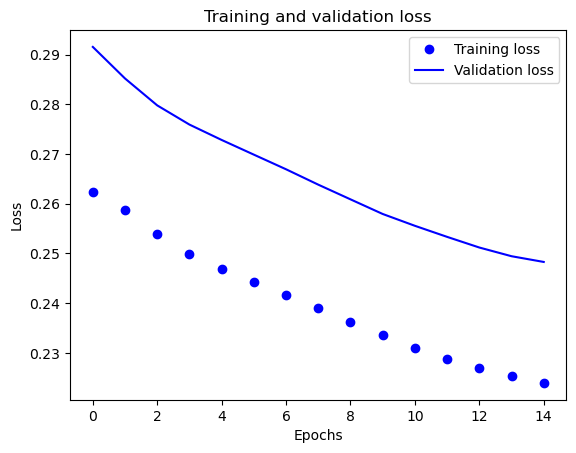

In [339]:
epochs = range(NUM_EPOCHS)

plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

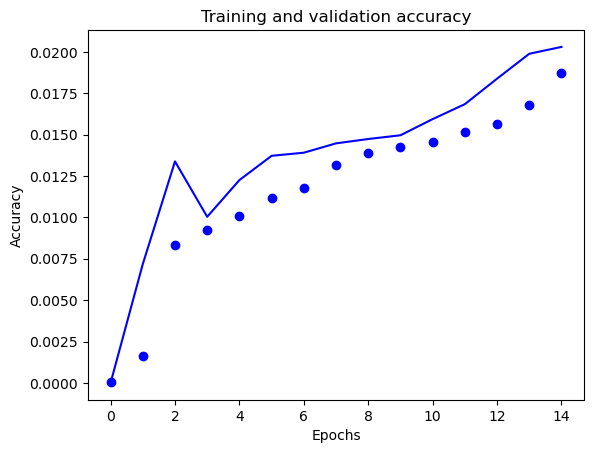

In [340]:
plt.plot(epochs, train_accs, 'bo', label='Training acc')
plt.plot(epochs, val_accs, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [341]:
# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    # print(ys)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        # print(ys) # Remove the comment to understand the loop
        if next_word == EOS_IDX:
            break
    return ys


In [342]:
text2codes(['Go!'], sp)[0].view(-1, 1)

tensor([[  1],
        [138],
        [  2]])

In [343]:
# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text2codes([src_sentence], sp)[0].view(-1, 1)
    print("SRC: ", src)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model, src, src_mask, max_len=num_tokens + 20, start_symbol=BOS_IDX).flatten()
    print("Targ: ", tgt_tokens)
    tgt_chars_specials = codes2text([tgt_tokens])
    tgt_chars = []
    for char in tgt_chars_specials:
        if char != '<s>' and char != '<\s>':
            tgt_chars += [char]
    tgt_chars = ''.join(tgt_chars)
    return tgt_chars


In [344]:
tgt_sent = translate(transformer, 'I drink water every day')
tgt_sent

SRC:  tensor([[ 1],
        [74],
        [ 2]])


NameError: name 'BOS_IDX' is not defined

In [ ]:
tgt = translate(transformer, "The house at the end of my street is red")
tgt

SRC:  tensor([[ 1],
        [85],
        [ 2]])
Targ:  tensor([   1,    8, 3907, 3907, 3907,    2])


'▁""""</s>'

In [ ]:
print(sp.decode_ids([  1,   8, 129, 144, 254, 144, 254, 144, 254, 144, 254, 144, 254, 144,
        254, 144, 254, 144, 254, 144,   2]))

"kt reara reara reara reara reara reara reara reara re
